# Generalized Latency Performance Estimation for Once-For-All Neural Architecture Search


## High Level Overview

<img src="latency_predictor/nas_overview.png" width=800 height=800 />

## Architecture

<img src="latency_predictor/lnas_architecture.png" width=900 height=900 />

In this notebook, we will be demonstrating:
- Latency predictor to predict latency of a given model architecture 
- Generalization of the Latency predictor over different hardware
- Effects of using Latency predictors in Neural Architecture Search paradigm (OFA)

## Initialization

Initialize OFA Code:

In [1]:
import torch
import numpy as np
import time
import random
import os
from collections import *

from accuracy_predictor import AccuracyPredictor

from latency_table import LatencyTable
from evolution_finder import EvolutionFinder
import csv
import pandas as pd

import sys
sys.path.append("..")
from ofa.model_zoo import ofa_net
import matplotlib.pyplot as plt

# set random seed
random_seed = 10291284
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
print('Successfully imported all packages and configured random seed to %d!'%random_seed)

Successfully imported all packages and configured random seed to 10291284!


In [2]:
cuda_available = torch.cuda.is_available()
if cuda_available:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    torch.cuda.manual_seed(random_seed)
    print('Using GPU.')
else:
    print('Using CPU.')

Using CPU.


In [3]:
ofa_network = ofa_net('ofa_mbv3_d234_e346_k357_w1.0', pretrained=True)
print('The OFA Network is ready.')
data_loader = None

The OFA Network is ready.


In [4]:
# Accuracy Predictor
accuracy_predictor = AccuracyPredictor(
    pretrained=True,
    device='cuda:0' if cuda_available else 'cpu'
)
print('The accuracy predictor is ready!')
print(accuracy_predictor.model)

The accuracy predictor is ready!
Sequential(
  (0): Linear(in_features=128, out_features=400, bias=True)
  (1): ReLU()
  (2): Linear(in_features=400, out_features=400, bias=True)
  (3): ReLU()
  (4): Linear(in_features=400, out_features=400, bias=True)
  (5): ReLU()
  (6): Linear(in_features=400, out_features=1, bias=True)
)


In [5]:
# Latency Predictor
target_hardware = 'note10'
latency_table = LatencyTable(device=target_hardware, use_latency_table=True)
print('The Latency lookup table on %s is ready!' % target_hardware)

Built latency table for image size: 160.
Built latency table for image size: 176.
Built latency table for image size: 192.
Built latency table for image size: 208.
Built latency table for image size: 224.
The Latency lookup table on note10 is ready!


/home/arvind/Desktop/Academics/Semester_3/Systems_ML/Project/compofa/tutorial/latency_table.py:23: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  self.lut = yaml.load(fp)


In [6]:
""" Hyper-parameters for the evolutionary search process
    You can modify these hyper-parameters to see how they influence the final ImageNet accuracy of the search sub-net.
"""
latency_constraint = 25  # ms, suggested range [15, 33] ms
P = 100  # The size of population in each generation
N = 500  # How many generations of population to be searched
r = 0.25  # The ratio of networks that are used as parents for next generation
params = {
    'constraint_type': target_hardware, # Let's do FLOPs-constrained search
    'efficiency_constraint': latency_constraint,
    'mutate_prob': 0.1, # The probability of mutation in evolutionary search
    'mutation_ratio': 0.5, # The ratio of networks that are generated through mutation in generation n >= 2.
    'efficiency_predictor': latency_table, # To use a predefined efficiency predictor.
    'accuracy_predictor': accuracy_predictor, # To use a predefined accuracy_predictor predictor.
    'population_size': P,
    'max_time_budget': N,
    'parent_ratio': r,
    'arch': 'compofa', ## change
}

# build the evolution finder
finder = EvolutionFinder(**params)

## Dataset Creation

Create dataset:

In [7]:
# time to create dataset
start = time.time()

# create latency dataset
number_of_datapoints = 10
latency_dataset = finder.create_latency_dataset(search_space='compofa', num_of_samples=number_of_datapoints)

# create dataset csv file
curr_hardware = 'note10_lookuptable' #'note10_lookuptable' #'Intel_Xeon_CPU' #RTX_2080_Ti_GPU'
filename = 'latency_predictor/datasets/' + curr_hardware + '_fixedkernelcompofa_test.csv'
with open(filename, 'w') as csv_file:
    w = csv.writer(csv_file)
    w.writerow(['child_arch', 'latency'])
    for i in range(len(latency_dataset['child_arch'])):
        child_arch = latency_dataset['child_arch'][i]
        latency = latency_dataset['latency'][i]
        w.writerow([child_arch, latency])

end = time.time()

print('Wrote Latency Dataset to File: {}'.format(filename))
print('Time to Create Dataset of {} points: {}'.format(number_of_datapoints, end-start))

completed 0/10 samples
completed 1/10 samples
completed 2/10 samples
completed 3/10 samples
completed 4/10 samples
completed 5/10 samples
completed 6/10 samples
completed 7/10 samples
completed 8/10 samples
completed 9/10 samples
Wrote Latency Dataset to File: latency_predictor/datasets/note10_lookuptable_fixedkernelcompofa_test.csv
Time to Create Dataset of 10 points: 0.005857229232788086


In [8]:
df = pd.read_csv('latency_predictor/datasets/note10_lookuptable_fixedkernelcompofa_test.csv', usecols=["child_arch", "latency"])
df

,child_arch,latency
0,"{'wid': None, 'ks': [3, 3, 3, 3, 5, 5, 5, 5, 3...",33.500156
1,"{'wid': None, 'ks': [3, 3, 3, 3, 5, 5, 5, 5, 3...",27.470840
2,"{'wid': None, 'ks': [3, 3, 3, 3, 5, 5, 5, 5, 3...",17.191669
3,"{'wid': None, 'ks': [3, 3, 3, 3, 5, 5, 5, 5, 3...",32.166314
4,"{'wid': None, 'ks': [3, 3, 3, 3, 5, 5, 5, 5, 3...",32.270490
5,"{'wid': None, 'ks': [3, 3, 3, 3, 5, 5, 5, 5, 3...",49.564905
6,"{'wid': None, 'ks': [3, 3, 3, 3, 5, 5, 5, 5, 3...",39.275898
7,"{'wid': None, 'ks': [3, 3, 3, 3, 5, 5, 5, 5, 3...",18.289627
8,"{'wid': None, 'ks': [3, 3, 3, 3, 5, 5, 5, 5, 3...",42.643404
9,"{'wid': None, 'ks': [3, 3, 3, 3, 5, 5, 5, 5, 3...",24.113853


## Latency Prediction Model 

<img src="latency_predictor/Latency_predictor_model.png" width=400 height=400 />

In [9]:
if '/latency_predictor' not in os.getcwd():
    os.chdir('./latency_predictor')
    
from latency_predictor import LatencyPredictor, RMSELoss, data_preprocessing, dataset_creation

LatencyPredictor device: cpu


### Evaluate Note10 OFA Model

In [10]:
from latency_encoding import latency_encoding

In [11]:
note10_checkpt = torch.load('../checkpoints/latency_prediction_model/Individual_trained_models/ofa/checkpoint_note10_ofa.pt')
note10_model = LatencyPredictor()
note10_model.load_state_dict(note10_checkpt)
criterion = RMSELoss()
#print(note10_model.model)

Load Note10 Dataset

In [12]:
dataset_path = 'datasets/Note10_LookupTable/note10_lookuptable_ofa.csv'#note10_lookuptable_elastickernelcompofa.csv'
df = pd.read_csv(dataset_path, usecols=["child_arch", "latency"])

Lets look at the data

In [13]:
df.head()

,child_arch,latency
0,"{'wid': None, 'ks': [7, 7, 3, 3, 5, 7, 3, 7, 3...",39.888340
1,"{'wid': None, 'ks': [7, 5, 5, 5, 3, 5, 3, 5, 3...",34.926996
2,"{'wid': None, 'ks': [5, 3, 7, 7, 7, 7, 7, 7, 5...",37.957898
3,"{'wid': None, 'ks': [7, 3, 7, 7, 3, 3, 7, 3, 3...",33.644811
4,"{'wid': None, 'ks': [7, 5, 5, 7, 5, 5, 3, 7, 3...",23.442201


In [14]:
df.iloc[0]['child_arch']

"{'wid': None, 'ks': [7, 7, 3, 3, 5, 7, 3, 7, 3, 7, 3, 7, 5, 7, 7, 5, 5, 5, 7, 5], 'e': [6, 3, 4, 4, 3, 6, 4, 6, 6, 3, 4, 6, 6, 3, 3, 4, 6, 4, 6, 6], 'd': [2, 4, 2, 3, 3], 'r': [208]}"

In [15]:
print("One hot encoding of the child architecture:")
latency_encoding(eval(df.iloc[0]['child_arch']))

One hot encoding of the child architecture:


tensor([[0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
         1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0.]])

In [16]:
print("Latency based on Look up Table:", df.iloc[0]['latency'], "ms")

Latency based on Look up Table: 39.888340486176574 ms


In [17]:
print("Latency based on Latency predictor:",note10_model.predict_efficiency(eval(df.iloc[0]['child_arch'])), "ms")

Latency based on Latency predictor: 40.03688430786133 ms


In [18]:
training_data, validation_data, test_data = data_preprocessing(dataset_path, 5000)
#test_data.head()

Vectoring child architecture via one hot encoding:

In [19]:
train_loader, validation_loader, test_dataset = dataset_creation(training_data, validation_data, test_data)
print("size of the test data set:", len(test_dataset))

size of the test data set: 1500


In [20]:
test_loss = []
for input_arch, target in test_dataset:
    prediction = note10_model(input_arch)[0][0]
    loss = criterion(prediction, target)
    test_loss.append(loss)

print("RMSE Loss over test data set:", torch.mean(torch.tensor(test_loss)), "ms")

RMSE Loss over test data set: tensor(0.3525) ms


### Evaluate RTX_2080_Ti_GPU OFA Model

In [21]:
RTX_checkpt = torch.load('../checkpoints/latency_prediction_model/Individual_trained_models/ofa/checkpoint_RTX_2080_Ti_GPU_ofa.pt')
RTX_model = LatencyPredictor()
RTX_model.load_state_dict(RTX_checkpt)
criterion = RMSELoss()
#print(RTX_model.model)

Load RTX Dataset

In [22]:
dataset_path = 'datasets/RTX_2080_Ti_GPU/RTX_2080_Ti_GPU_ofa.csv'
df_RTX = pd.read_csv(dataset_path, usecols=["child_arch", "latency"])
#df_RTX.head()

In [23]:
df_RTX.iloc[0]['child_arch']

"{'wid': None, 'ks': [7, 7, 3, 3, 5, 7, 3, 7, 3, 7, 3, 7, 5, 7, 7, 5, 5, 5, 7, 5], 'e': [6, 3, 4, 4, 3, 6, 4, 6, 6, 3, 4, 6, 6, 3, 3, 4, 6, 4, 6, 6], 'd': [2, 4, 2, 3, 3], 'r': [208]}"

In [24]:
sample_child_arch = eval(df_RTX.iloc[0]['child_arch'])
sample_latency = df_RTX.iloc[0]['latency']
print("Latency from look up table:", sample_latency, "ms")

Latency from look up table: 20.59500217437744 ms


In [25]:
print("Latency from latency predictor: ", RTX_model.predict_efficiency(sample_child_arch), "ms")

Latency from latency predictor:  20.724504470825195 ms


In [26]:
training_data, validation_data, test_data = data_preprocessing(dataset_path, 5000)
train_loader, validation_loader, test_dataset = dataset_creation(training_data, validation_data, test_data)
#len(test_dataset)

In [27]:
test_loss = []
for input_arch, target in test_dataset:
    prediction = RTX_model(input_arch)[0][0]
    loss = criterion(prediction, target)
    test_loss.append(loss)

print("RMSE loss over test dataset: ", torch.mean(torch.tensor(test_loss)), "ms")

RMSE loss over test dataset:  tensor(0.3859) ms


### Evaluate Finetuned RTX_2080_Ti_GPU Model using Note10 Base

In [28]:
RTX_checkpt = torch.load('../checkpoints/latency_prediction_model/Finetune_Note_10/checkpoint_finetune_RTX_2080_Ti_GPU_ofa.pt')

finetune=True
if finetune:
    key_names = ["model.0.weight", "model.0.bias", "model.2.weight", "model.2.bias", "model.4.weight", "model.4.bias", "model.6.weight", "model.6.bias"]
    new_state_dict = OrderedDict()
    i = 0
    for k, v in RTX_checkpt.items():
        new_state_dict[key_names[i]] = v
        i = i + 1
    RTX_checkpt = new_state_dict

RTX_model = LatencyPredictor()
RTX_model.load_state_dict(RTX_checkpt)
criterion = RMSELoss()

In [29]:
dataset_path = 'datasets/RTX_2080_Ti_GPU/RTX_2080_Ti_GPU_ofa.csv'
df_RTX = pd.read_csv(dataset_path, usecols=["child_arch", "latency"])
#df_RTX.head()

In [30]:
print(df_RTX.iloc[0]['child_arch'])

{'wid': None, 'ks': [7, 7, 3, 3, 5, 7, 3, 7, 3, 7, 3, 7, 5, 7, 7, 5, 5, 5, 7, 5], 'e': [6, 3, 4, 4, 3, 6, 4, 6, 6, 3, 4, 6, 6, 3, 3, 4, 6, 4, 6, 6], 'd': [2, 4, 2, 3, 3], 'r': [208]}


In [31]:
sample_child_arch = eval(df_RTX.iloc[0]['child_arch'])
sample_latency = df_RTX.iloc[0]['latency']
print("Latency based on look up table", sample_latency, "ms")

Latency based on look up table 20.59500217437744 ms


In [32]:
print("Latency based on fine-tuned latency predictor:", RTX_model.predict_efficiency(sample_child_arch), "ms")

Latency based on fine-tuned latency predictor: 22.062299728393555 ms


In [33]:
training_data, validation_data, test_data = data_preprocessing(dataset_path, 5000)
train_loader, validation_loader, test_dataset = dataset_creation(training_data, validation_data, test_data)
#len(test_dataset)

In [34]:
test_loss = []
for input_arch, target in test_dataset:
    prediction = RTX_model(input_arch)[0][0]
    loss = criterion(prediction, target)
    test_loss.append(loss)

print("RMSE loss over test dataset:", torch.mean(torch.tensor(test_loss)), "ms")

RMSE loss over test dataset: tensor(0.7128) ms


# Inference Time Analysis

In [35]:
from latency_encoding import latency_encoding

In [36]:
sample_child_arch = eval(df.iloc[0]['child_arch'])
sample_latency = df.iloc[0]['latency']
print('Child_Arch: {}, \n\nLatency: {}'.format(sample_child_arch, sample_latency))

Child_Arch: {'wid': None, 'ks': [7, 7, 3, 3, 5, 7, 3, 7, 3, 7, 3, 7, 5, 7, 7, 5, 5, 5, 7, 5], 'e': [6, 3, 4, 4, 3, 6, 4, 6, 6, 3, 4, 6, 6, 3, 3, 4, 6, 4, 6, 6], 'd': [2, 4, 2, 3, 3], 'r': [208]}, 

Latency: 39.888340486176574


In [37]:
sample_child_arch_encoded = latency_encoding(sample_child_arch)
sample_child_arch_encoded

tensor([[0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
         1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0.]])

Estimation Time using Latency Prediction Model:

With encoding and memoization:

In [38]:
times = []
for i in range(1):
    start = time.time()

    prediction = RTX_model.predict_efficiency(sample_child_arch)

    end = time.time()

    model_time = end - start
    times.append(model_time)
    #print(model_time)
print(sum(times)/len(times))

1.0251998901367188e-05


Estimation Time using Note10 Lookup Table (Previous Method):

In [39]:
times = []
for i in range(1):
    start = time.time()

    prediction = finder.efficiency_predictor.predict_efficiency(sample_child_arch)

    end = time.time()
    lookup_time = end - start
    times.append(lookup_time)
print(sum(times)/len(times))

9.799003601074219e-05


# Neural Architecture Search

Using Note10 Lookup Table as the Performance Estimation 

In [40]:
""" Hyper-parameters for the evolutionary search process
    You can modify these hyper-parameters to see how they influence the final ImageNet accuracy of the search sub-net.
"""
latency_constraint = 25  # ms, suggested range [15, 33] ms
P = 100  # The size of population in each generation
N = 500  # How many generations of population to be searched
r = 0.25  # The ratio of networks that are used as parents for next generation
target_hardware = 'note10'
params = {
    'constraint_type': target_hardware, # Let's do FLOPs-constrained search
    'efficiency_constraint': latency_constraint,
    'mutate_prob': 0.1, # The probability of mutation in evolutionary search
    'mutation_ratio': 0.5, # The ratio of networks that are generated through mutation in generation n >= 2.
    'efficiency_predictor': latency_table, # To use a predefined efficiency predictor.
    'accuracy_predictor': accuracy_predictor, # To use a predefined accuracy_predictor predictor.
    'population_size': P,
    'max_time_budget': N,
    'parent_ratio': r,
    'arch': 'compofa', ## change
}

# build the evolution finder
finder = EvolutionFinder(**params)

In [41]:
result_lis1 = []
latency_constraint = 20
st = time.time()
finder.set_efficiency_constraint(latency_constraint)
best_valids, best_info = finder.run_evolution_search()
ed = time.time()
result_lis1.append(best_info)
print("Done! Time Taken: {} seconds".format(ed-st))

Searching with note10 constraint (20): 100%|██████████| 500/500 [00:15<00:00, 31.32it/s]

Done! Time Taken: 16.12386918067932 seconds


In [42]:
result_lis1

[(0.7964891195297241,
  {'wid': None,
   'ks': [3, 3, 3, 3, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5],
   'e': [3, 3, 3, 3, 4, 4, 4, 4, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4],
   'd': [2, 3, 2, 3, 3],
   'r': [192]},
  19.88688251867145)]

Using Latency Prediction Model as the Performance Estimation 

In [43]:
""" Hyper-parameters for the evolutionary search process
    You can modify these hyper-parameters to see how they influence the final ImageNet accuracy of the search sub-net.
"""
latency_constraint = 25  # ms, suggested range [15, 33] ms
P = 100  # The size of population in each generation
N = 500  # How many generations of population to be searched
r = 0.25  # The ratio of networks that are used as parents for next generation
target_hardware = 'note10'
params = {
    'constraint_type': target_hardware, # Let's do FLOPs-constrained search
    'efficiency_constraint': latency_constraint,
    'mutate_prob': 0.1, # The probability of mutation in evolutionary search
    'mutation_ratio': 0.5, # The ratio of networks that are generated through mutation in generation n >= 2.
    'efficiency_predictor': note10_model, # To use a predefined efficiency predictor.
    'accuracy_predictor': accuracy_predictor, # To use a predefined accuracy_predictor predictor.
    'population_size': P,
    'max_time_budget': N,
    'parent_ratio': r,
    'arch': 'compofa', ## change
}

# build the evolution finder
finder = EvolutionFinder(**params)

In [44]:
result_lis2 = []
latency_constraint = 20
st = time.time()
finder.set_efficiency_constraint(latency_constraint)
best_valids, best_info = finder.run_evolution_search()
ed = time.time()
result_lis2.append(best_info)
print("Done! Time Taken: {} seconds".format(ed-st))

Searching with note10 constraint (20): 100%|██████████| 500/500 [00:11<00:00, 43.57it/s]

Done! Time Taken: 11.676002025604248 seconds


In [45]:
result_lis2

[(0.8171635866165161,
  {'wid': None,
   'ks': [3, 3, 3, 3, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5],
   'e': [3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 4, 4, 4, 4],
   'd': [2, 3, 3, 4, 3],
   'r': [224]},
  18.693700790405273)]

In [46]:
accuracy_predictor.predict_accuracy([result_lis1[0][1], result_lis2[0][1]])

tensor([[0.7965],
        [0.8172]])

### Application in NAS Experiments

#### Comparison of pareto frontier of NAS (look up) vs NAS (latency predictor) 

#### Note10

Search Space: Fixed Kernel CompOFA

5 constraints: 15, 20, 25, 30, 35

Target Hardware: Note10

Note10 Lookup Table Results: 

Top1 Accuracy:
[72.80000114440918, 75.20000076293945, 75.70000076293945, 75.80000305175781, 75.9000015258789]

Top5 Accuracy:
[91.1, 92.1, 93.2, 93.3, 93.5]

Latency:
[14.69766178609321, 19.88688251867145, 24.83390000854306, 29.512724161788654, 34.79207886302561]

Time for NAS: 90.72894263267517

Note10_OFA Model Latency Prediction Results:

Top1 Accuracy:
[73.40000343322754, 76.0, 75.30000305175781, 76.10000038146973, 76.00000190734863]

Top5 Accuracy:
[91.4, 92.2, 92.8, 93.3, 93.3]

Latency:
[14.7567, 18.6498, 24.8855, 29.4332, 32.4759]


Time for NAS: 175.0260510444641

Note10_OFA Model Latency Prediction WITH Memoization Results:

Top1 Accuracy:
[75.80000114440918, 76.80000114440918, 76.80000305175781, 77.30000114440918, 77.20000267028809]

Top5 Accuracy:
[92.7, 93.1, 93.8, 94.5, 94.4]

Latency:
[14.7567, 18.6498, 24.8855, 29.4332, 32.4759]


Time for NAS: 59.26314926147461

In [47]:
lookup_table_top1 = [72.8, 75.2, 75.7, 75.8, 75.9]
lookup_table_top5 = [91.1, 92.1, 93.2, 93.3, 93.5]
lookup_table_latency = [14.69, 19.88, 24.83, 29.51, 34.79]

model_top1 = [73.4, 76.0, 75.3, 76.1, 76.0]
model_top5 = [91.4, 92.2, 92.8, 93.3, 93.3]
model_latency = [14.75, 18.64, 24.88, 29.43, 32.47]

model_memo_top1 = [75.8, 76.8, 76.8, 77.3, 77.2]
model_memo_top5 = [92.7, 93.1, 93.8, 94.5, 94.4]
model_memo_latency = [14.75, 18.64, 24.88, 29.43, 32.47]

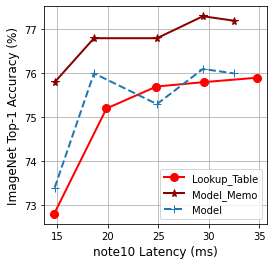

In [48]:
plt.figure(figsize=(4,4))
plt.plot(lookup_table_latency, lookup_table_top1, 'x-', marker='o', color='red',  linewidth=2, markersize=8, label='Lookup_Table')
plt.plot(model_memo_latency, model_memo_top1, 'x-', marker='*', color='darkred',  linewidth=2, markersize=8, label='Model_Memo')
plt.plot(model_latency, model_top1, '--', marker='+', linewidth=2, markersize=8, label='Model')
plt.xlabel('%s Latency (ms)' % target_hardware, size=12)
plt.ylabel('ImageNet Top-1 Accuracy (%)', size=12)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

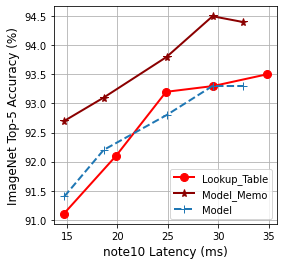

In [49]:
plt.figure(figsize=(4,4))
plt.plot(lookup_table_latency, lookup_table_top5, 'x-', marker='o', color='red',  linewidth=2, markersize=8, label='Lookup_Table')
plt.plot(model_memo_latency, model_memo_top5, 'x-', marker='*', color='darkred',  linewidth=2, markersize=8, label='Model_Memo')
plt.plot(model_latency, model_top5, '--', marker='+', linewidth=2, markersize=8, label='Model')
plt.xlabel('%s Latency (ms)' % target_hardware, size=12)
plt.ylabel('ImageNet Top-5 Accuracy (%)', size=12)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

#### Note10

Search Space: Elastic Kernel CompOFA

5 constraints: 15, 20, 25, 30, 35

Target Hardware: Note10

Note10 Lookup Table Results: 

Top1 Accuracy:
[73.30000305175781, 75.80000114440918, 75.70000267028809, 76.30000305175781, 76.4000015258789]

Top5 Accuracy:
[90.2, 91.9, 93.0, 93.2, 93.8]

Latency:
[14.883577352241502, 19.9517505771064, 24.523907686903634, 29.628799671866894, 34.987063535187986]

Time for NAS: 105.40677523612976

Note10_OFA Model Latency Prediction Results:

Top1 Accuracy:
[73.4000015258789, 75.80000114440918, 75.30000114440918, 77.70000076293945, 76.60000228881836]

Top5 Accuracy:
[91.3, 92.6, 93.3, 93.4, 93.7]

Latency:
[14.845640182495117, 19.97205352783203, 24.33823585510254, 29.964521408081055, 34.266754150390625]


Time for NAS: 223.74719524383545

Note10_OFA Model Latency Prediction WITH Memoization Results:

Top1 Accuracy:
[76.00000190734863, 76.40000343322754, 76.80000114440918, 77.4000015258789, 77.30000305175781]

Top5 Accuracy:
[92.7, 93.6, 94.3, 94.9, 94.6]

Latency:
[14.730718612670898, 19.913232803344727, 23.94869613647461, 29.688018798828125, 31.26772689819336]


Time for NAS: 173.9402687549591

In [50]:
lookup_table_top1 = [73.3, 75.8, 75.7, 76.3, 76.4]
lookup_table_top5 = [90.2, 91.9, 93.0, 93.2, 93.8]
lookup_table_latency = [14.88, 19.95, 24.52, 29.62, 34.98]

model_top1 = [73.4, 75.8, 75.3, 77.7, 76.6]
model_top5 = [91.3, 92.6, 93.3, 93.4, 93.7]
model_latency = [14.84, 19.97, 24.33, 29.96, 34.26]

model_memo_top1 = [76.0, 76.4, 76.8, 77.4, 77.3]
model_memo_top5 = [92.7, 93.6, 94.3, 94.9, 94.6]
model_memo_latency = [14.73, 19.91, 23.94, 29.68, 31.26]

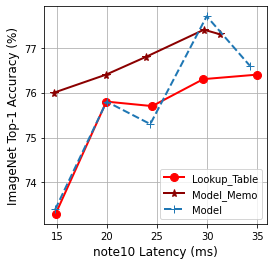

In [51]:
plt.figure(figsize=(4,4))
plt.plot(lookup_table_latency, lookup_table_top1, 'x-', marker='o', color='red',  linewidth=2, markersize=8, label='Lookup_Table')
plt.plot(model_memo_latency, model_memo_top1, 'x-', marker='*', color='darkred',  linewidth=2, markersize=8, label='Model_Memo')
plt.plot(model_latency, model_top1, '--', marker='+', linewidth=2, markersize=8, label='Model')
plt.xlabel('%s Latency (ms)' % target_hardware, size=12)
plt.ylabel('ImageNet Top-1 Accuracy (%)', size=12)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

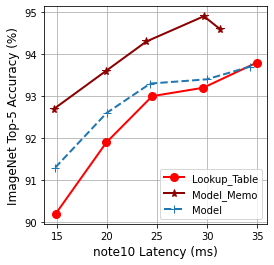

In [52]:
plt.figure(figsize=(4,4))
plt.plot(lookup_table_latency, lookup_table_top5, 'x-', marker='o', color='red',  linewidth=2, markersize=8, label='Lookup_Table')
plt.plot(model_memo_latency, model_memo_top5, 'x-', marker='*', color='darkred',  linewidth=2, markersize=8, label='Model_Memo')
plt.plot(model_latency, model_top5, '--', marker='+', linewidth=2, markersize=8, label='Model')
plt.xlabel('%s Latency (ms)' % target_hardware, size=12)
plt.ylabel('ImageNet Top-5 Accuracy (%)', size=12)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

#### RTX 2080 Ti GPU

Search Space: CompOFA

5 constraints: 15, 20, 25, 30, 35

Target Hardware: gpu

Latency Measurement Results: 

Top1 Accuracy:
[76.9000015258789, 76.70000076293945, 76.79999923706055, 77.20000267028809, 76.80000305175781]

Top5 Accuracy:
[94.2, 94.2, 94.5, 94.4, 94.2]

Latency:
[14.194464683532715, 17.401909828186035, 17.401909828186035, 17.401909828186035, 33.16640853881836]

Time for NAS: 202.69879007339478

RTX_OFA Model Latency Prediction WITH Memoization Results:

Top1 Accuracy:
[77.39999961853027, 77.00000190734863, 77.4000015258789, 77.00000190734863, 76.5]

Top5 Accuracy:
[94.0, 94.2, 94.2, 94.3, 94.5]

Latency:
[13.162400245666504, 15.776034355163574, 15.776034355163574, 15.776034355163574, 32.576904296875]


Time for NAS: 57.54925608634949

RTX_OFA Note10_FineTuned Model Latency Prediction WITH Memoization Results:

Top1 Accuracy:
[76.20000076293945, 77.70000267028809, 77.00000190734863, 76.70000076293945, 77.20000267028809]

Top5 Accuracy:
[94.2, 94.4, 94.2, 94.3, 94.2]

Latency:
[14.683911323547363, 15.258056640625, 15.258056640625, 29.110185623168945, 31.35794448852539]


Time for NAS: 57.574804067611694

In [53]:
measure_top1 = [76.90, 76.70, 76.79, 77.20, 76.80]
measure_top5 = [94.2, 94.2, 94.5, 94.4, 94.2]
measure_latency = [14.19, 17.40, 17.40, 17.40, 33.16]

model_top1 = [77.39, 77.00, 77.40, 77.00, 76.50]
model_top5 = [94.0, 94.2, 94.2, 94.3, 94.5]
model_latency = [13.16, 15.77, 15.77, 15.77, 32.57]

finetuned_top1 = [76.20, 77.70, 77.00, 76.70, 77.20]
finetuned_top5 = [94.2, 94.4, 94.2, 94.3, 94.2]
finetuned_latency = [14.68, 15.25, 15.25, 29.11, 31.35]

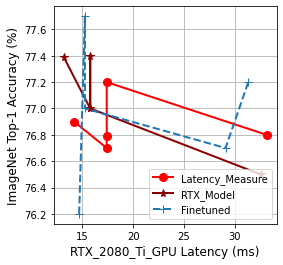

In [54]:
target_hardware = 'RTX_2080_Ti_GPU'
plt.figure(figsize=(4,4))
plt.plot(measure_latency, measure_top1, 'x-', marker='o', color='red',  linewidth=2, markersize=8, label='Latency_Measure')
plt.plot(model_latency, model_top1, 'x-', marker='*', color='darkred',  linewidth=2, markersize=8, label='RTX_Model')
plt.plot(finetuned_latency, finetuned_top1, '--', marker='+', linewidth=2, markersize=8, label='Finetuned')
plt.xlabel('%s Latency (ms)' % target_hardware, size=12)
plt.ylabel('ImageNet Top-1 Accuracy (%)', size=12)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

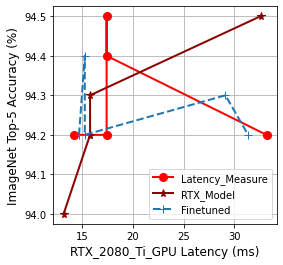

In [55]:
target_hardware = 'RTX_2080_Ti_GPU'
plt.figure(figsize=(4,4))
plt.plot(measure_latency, measure_top5, 'x-', marker='o', color='red',  linewidth=2, markersize=8, label='Latency_Measure')
plt.plot(model_latency, model_top5, 'x-', marker='*', color='darkred',  linewidth=2, markersize=8, label='RTX_Model')
plt.plot(finetuned_latency, finetuned_top5, '--', marker='+', linewidth=2, markersize=8, label='Finetuned')
plt.xlabel('%s Latency (ms)' % target_hardware, size=12)
plt.ylabel('ImageNet Top-5 Accuracy (%)', size=12)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

#### RTX 2080 Ti GPU

#### Comparison of Finetuned Model with Hardware specific model

Search Space: Elastic Kernel CompOFA

5 constraints: 15, 20, 25, 30, 35

Target Hardware: gpu

RTX_OFA Model Latency Prediction WITH Memoization Results:

Top1 Accuracy:
[77.10000228881836, 77.40000343322754, 77.30000114440918, 77.20000076293945, 77.90000343322754]

Top5 Accuracy:
[94.5, 94.8, 94.8, 95.0, 94.7]

Latency:
[14.033023834228516, 17.6427001953125, 24.21096420288086, 22.906673431396484, 23.46289825439453]


Time for NAS: 147.10737991333008

RTX_OFA Note10_FineTuned Model Latency Prediction WITH Memoization Results:

Top1 Accuracy:
[76.70000076293945, 78.10000038146973, 77.10000038146973, 78.20000076293945, 76.80000114440918]

Top5 Accuracy:
[93.8, 94.5, 94.6, 94.6, 94.8]

Latency:
[14.805492401123047, 19.535118103027344, 22.045217514038086, 26.886178970336914, 34.85415267944336]


Time for NAS: 139.161794424057

In [56]:
model_top1 = [77.10, 77.40, 77.30, 77.20, 77.90]
model_top5 = [94.5, 94.8, 94.8, 95.0, 94.7]
model_latency = [14.03, 17.64, 24.21, 22.90, 23.46]

finetuned_top1 = [76.70, 78.10, 77.10, 78.20, 76.80]
finetuned_top5 = [93.8, 94.5, 94.6, 94.6, 94.8]
finetuned_latency = [14.80, 19.53, 22.04, 26.88, 34.85]

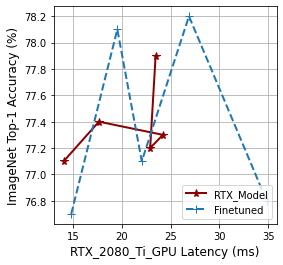

In [57]:
target_hardware = 'RTX_2080_Ti_GPU'
plt.figure(figsize=(4,4))
plt.plot(model_latency, model_top1, 'x-', marker='*', color='darkred',  linewidth=2, markersize=8, label='RTX_Model')
plt.plot(finetuned_latency, finetuned_top1, '--', marker='+', linewidth=2, markersize=8, label='Finetuned')
plt.xlabel('%s Latency (ms)' % target_hardware, size=12)
plt.ylabel('ImageNet Top-1 Accuracy (%)', size=12)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

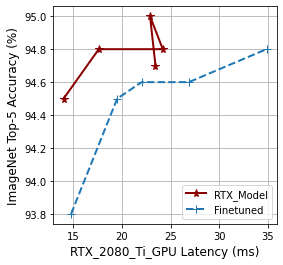

In [58]:
target_hardware = 'RTX_2080_Ti_GPU'
plt.figure(figsize=(4,4))
plt.plot(model_latency, model_top5, 'x-', marker='*', color='darkred',  linewidth=2, markersize=8, label='RTX_Model')
plt.plot(finetuned_latency, finetuned_top5, '--', marker='+', linewidth=2, markersize=8, label='Finetuned')
plt.xlabel('%s Latency (ms)' % target_hardware, size=12)
plt.ylabel('ImageNet Top-5 Accuracy (%)', size=12)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()